# 플레이리스트에 가장 어울리는 곡 예측하기

## 목차 
0. [시작하기 앞서](#0.-시작하기-앞서)  
    이 대회를 리뷰하고자 하는 이유
1. [소개]  
    대회 소개  
    추천 시스템 소개  
    평가 지표
2. [EDA]  
    환경 설정  
    데이터 불러오기  
    - train, test, val  
    - genre_gn_all  
    - song_meta

## 0. 시작하기 앞서
### 이 대회를 리뷰하고자 하는 이유
딥러닝 모델에 train 데이터를 적용시켜 주제에 맞는 결과를 도출하는 목표를 잠시 제쳐 두고, 데이터 전처리 및 시각화를 통해 유의미한 정보를 얻어보는 **데이터를 이해하는 시간**을 갖고 싶었다.

학습을 위해 적절한 양의 데이터도 중요했지만 우선 흥미로운 주제로 스스로 동기부여를 시켜 정말 순수하게 데이터 탐구를 시도해보려고 하였다.

> Reference:
- https://arena.kakao.com/c/8 (대회소개)
- https://brunch.co.kr/@kakao-it/342 (멜론 추천 시스템 원리)
- https://brunch.co.kr/@kakao-it/343 ([brunch] EDA)
- https://arena.kakao.com/forum/topics/191 ([KakaoArena] EDA)
- https://arena.kakao.com/forum/topics/228 ([NoteBook] EDA by kimhyunwoo)


In [32]:
# 기본 환경 설정

from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re

import numpy as np
import pandas as pd

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
!pip install konlpy
from konlpy.tag import Twitter
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters

In [33]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 이거 실행한 후 런타임 다시 시작 필수! (Ctrl + M, Ctrl + F9)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나중에 word cloud를 위함
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
# plt.rc('font', family=font_name, size=12)
plt.rc('font', family='NanumGothic', size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

# mpl.font_manager._rebuild()
# mpl.pyplot.rc('font', family='NanumGothic')

In [35]:
# 나눔 글꼴 설치됐는지 확인
sys_fonts = fm.findSystemFonts()
[f for f in sys_fonts if 'Nanum' in f]

['/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf']

In [36]:
pd.options.mode.chained_assignment = None

In [37]:
# [google Colab 환경 설정]
from google.colab import drive
drive.mount('/content/drive/')

# os.chdir('drive/MyDrive/Colab Notebooks/Kaggle_Study/KaKao')
!pwd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Kaggle_Study/KaKao


## 0. 데이터 셋 다운 받기
[데이터 셋](https://arena.kakao.com/c/8/data)을 다운 받는다. 나는 바로 다운로드 기능이 정상적으로 이루어지지 않아 다운로드 링크를 클릭하여 Google Drive에 바로 다운 받았다.

In [38]:
os.listdir() # input 폴더에 있는 파일 보기 → [train, test, val, genre_gn_all, song_meta] 으로 이루어짐

['[카카오아레나] Melon Playlist Continuation.ipynb',
 'train.json',
 'val.json',
 'test.json',
 'genre_gn_all.json',
 'song_meta.json']

## 1. 데이터 불러오기


In [39]:
train = pd.read_json("train.json")
test = pd.read_json("test.json")
val = pd.read_json("val.json")
genre_gn_all = pd.read_json("genre_gn_all.json", typ = 'series')
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})
# index가 'GN0000' 문자열 이므로 reset_index 필요
song_meta = pd.read_json("song_meta.json")

### 1.1 곡 장르 코드 데이터: genre_gn_all.json
- gnr_code: 장르코드
- gnr_name: 장르명

장르코드는 총 254개 (대분류 장르코드는 30개, 상세분류는 224개)


In [40]:
genre_gn_all

,gnr_code,gnr_name
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
...,...,...
249,GN2900,뮤지컬
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬
252,GN2903,국외뮤지컬


#### 대분류 장르코드
대분류 장르코드는 장르코드(gnr_code)에서 숫자 네 자리 중 뒷자리 두 자리가 00인 코드로 분류할 수 있음.  
대분류 장르는 총 30개가 있음.

In [41]:
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']
gnr_code

,gnr_code,gnr_name
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


#### 상세 장르코드
상세 장르코드는 장르코드(gnr_code)에서 숫자 네 자리 중 뒷자리 두 자리가 00이 아닌 나머지 코드로 분류할 수 있음.  
상세 장르는 총 224개가 있음.

In [42]:
# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

dtl_gnr_code

,dtl_gnr_code,dtl_gnr_name
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
5,GN0105,'10-
...,...,...
247,GN2805,숙면유도
248,GN2806,반려동물
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬


#### 장르 코드 트리 (Tree)
[pandas.DataFrame.assign](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html)함수를 이용하여 새로운 column을 부여하면서 
[pandas.DataFrame.merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html)로 연결고리를 만들어 줌.

※총 225개의 열이 나오는 데 마지막 GN3000 크리스마스의 경우 세부 장르가 없음을 확인 가능.

In [43]:
# 앞자리 네 자리 공통코드 추출
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-
...,...,...,...,...
220,GN2800,뮤직테라피,GN2806,반려동물
221,GN2900,뮤지컬,GN2901,세부장르전체
222,GN2900,뮤지컬,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN2903,국외뮤지컬


In [44]:
gnr_code_tree

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN01,GN0101,세부장르전체
1,GN0100,발라드,GN01,GN0102,'80
2,GN0100,발라드,GN01,GN0103,'90
3,GN0100,발라드,GN01,GN0104,'00
4,GN0100,발라드,GN01,GN0105,'10-
...,...,...,...,...,...
220,GN2800,뮤직테라피,GN28,GN2806,반려동물
221,GN2900,뮤지컬,GN29,GN2901,세부장르전체
222,GN2900,뮤지컬,GN29,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN29,GN2903,국외뮤지컬


### 1.2 곡 별 메타 데이터: song_meta.json

In [45]:
song_meta

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4
...,...,...,...,...,...,...,...,...,...
707984,[GN2001],19991219,The Best Best Of The Black President,65254,[166499],Coffin For Head Of State,[GN2000],[Fela Kuti],707984
707985,[GN0901],19860000,True Colors,44141,[11837],Change Of Heart,[GN0900],[Cyndi Lauper],707985
707986,"[GN0105, GN0101]",20160120,행보 2015 윤종신 / 작사가 윤종신 Live Part.1,2662866,[437],스치듯 안녕,[GN0100],[윤종신],707986
707987,"[GN1807, GN1801]",20131217,명상의 시간을 위한 뉴에이지 음악,2221722,[729868],숲의 빛,[GN1800],[Nature Piano],707987


총 707,989곡의 메타 정보가 담겨 있으며 포함하는 값은 아래와 같다.
- song_gn_dtl_gnr_basket : 상세 장르 코드
- issue_date : 곡 발매 일자 (yyyymmdd)
- album_name : 앨범 명
- album_id : 앨범 아이디
- artist_id_basket : 아티스트 아이디 (복수일 경우 띄어쓰기로 구분)
- song_name : 곡 명
- song_gn_gnr_basket : 대분류 장르코드
- artist_name_basket : 아티스트 명 (복수일 경우 띄어쓰기로 구분)
- id : 곡 아이디

In [46]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


#### 곡 별 매핑되는 장르 수는?
**unnest**란? '중첩 해제' 라는 뜻으로 여기서는 두개 이상의 장르 구분을 가진 곡 데이터에 대해 1 row당 1 장르를 갖도록 펼쳐 보이는 작업을 말함.

```python
list(map(함수, list 변수)) # return new list
np.repeat(array_like, int || array of ints) # return 1-D ndarray
np.concatenate(seq of array_like) # return 1-D ndarray (if axis=None)
np.dstack(tuple) # return 3-D ndarray (단, tuple 에 들어있는  array들의 원소 shape이 같아야 함)
```
[numpy.dstack](https://numpy.org/doc/stable/reference/generated/numpy.dstack.html)함수(*Examples 볼것!*)를 사용하여 np.repeat으로 복수 장르 가진 곡의 장르 수 만큼 id 원소를 늘리고, np.concatenate으로 1차원 배열을 반환 시켜 동일한 길이의 두 배열을 연결 시켜주는 작업을 한다.

In [47]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)
# inplace = True: 출력 뿐 아니라 원본 데이터에도 영향

# unnest 객체 제거
del song_gnr_map_unnest

In [48]:
song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


```python
pd.df.nunique() # return Series
```
장르 수를 count 하기 위해 nunique함수를 쓴다.

`'song_id'`로 groupby 된 Group DataFrame 중 `gnr_code` column에 대해 count한 값의 column명은 `'mapping_gnr_cnt'`라고 명명하고,  
다시 `'mapping_gnr_cnt'`에 대해 groupby 시켜 한 곡이 가진 장르 개수인 `'매핑된 곡 수'`column을 만들어 `'gnr_song_count'` DataFrame을 생성. → 바로 다음 시각화 자료로 쓰임.

In [49]:
# 1. 곡 별 장르 개수 count 테이블 생성 : song_gnr_count
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')

# 2. 1번에서 생성한 테이블을 가지고 매핑된 장르 개수 별 곡 수 count 테이블 생성 : gnr_song_count
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')

# 3. 2번 테이블에 비율 값 추가
gnr_song_count.loc[:, '비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100, 2)
gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
gnr_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]

,장르 수,매핑된 곡 수,비율(%)
0,1,612806,86.69
1,2,92378,13.07
2,3,1694,0.24
3,4,48,0.01
4,5,1,0.00
5,6,3,0.00


- 대부분의 곡들은 한 개의 대분류 장르와 매핑되어 있음.  
- 전체 곡의 약 13%는 2개 이상의 대분류 장르를 가짐.

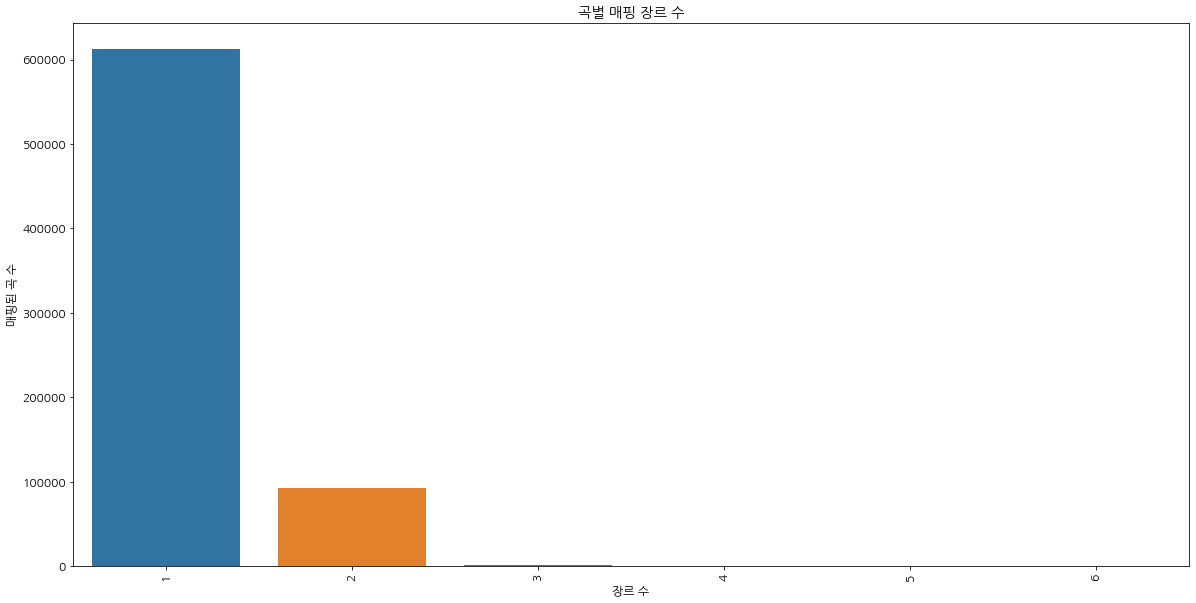

In [50]:
# 매핑 장르 수 시각화 (개인 과제)
# plotting
gnr_song_code_name_plot = sns.barplot(x = '장르 수', y = '매핑된 곡 수', data = gnr_song_count)
gnr_song_code_name_plot.set_title('곡별 매핑 장르 수')
gnr_song_code_name_plot.set_xlabel('장르 수')
gnr_song_code_name_plot.set_ylabel('매핑된 곡 수')
plt.xticks(rotation = 90)
plt.show()

In [51]:
# song_gnr_count[song_gnr_count['mapping_gnr_cnt'] >= 2]

# Ex. 5개 장르를 가지고 있는 곡
song_meta[song_meta['id'] == 187305]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
187305,"[GN0101, GN0401, GN0801, GN0301, GN0601, GN0201]",20180405,B`Cusic 2018,10154329,[2113493],Deep asleep,"[GN0100, GN0400, GN0800, GN0300, GN0600, GN0200]",[송혜원],187305


#### 가장 많이 매핑되는 장르는?
- POP 장르(GN0900)의 곡 비중이 가장 높았고, 국악, 뮤지컬, 뮤직테라피, 종교음악 등의 장르 비중은 1% 미만의 비중을 보임.
- 아이돌 아티스트 관련 장르인 아이돌 장르(GN2500)와 댄스 장르(GN0200) 비중도 비교적 낮게 나타나는 점이 보임.

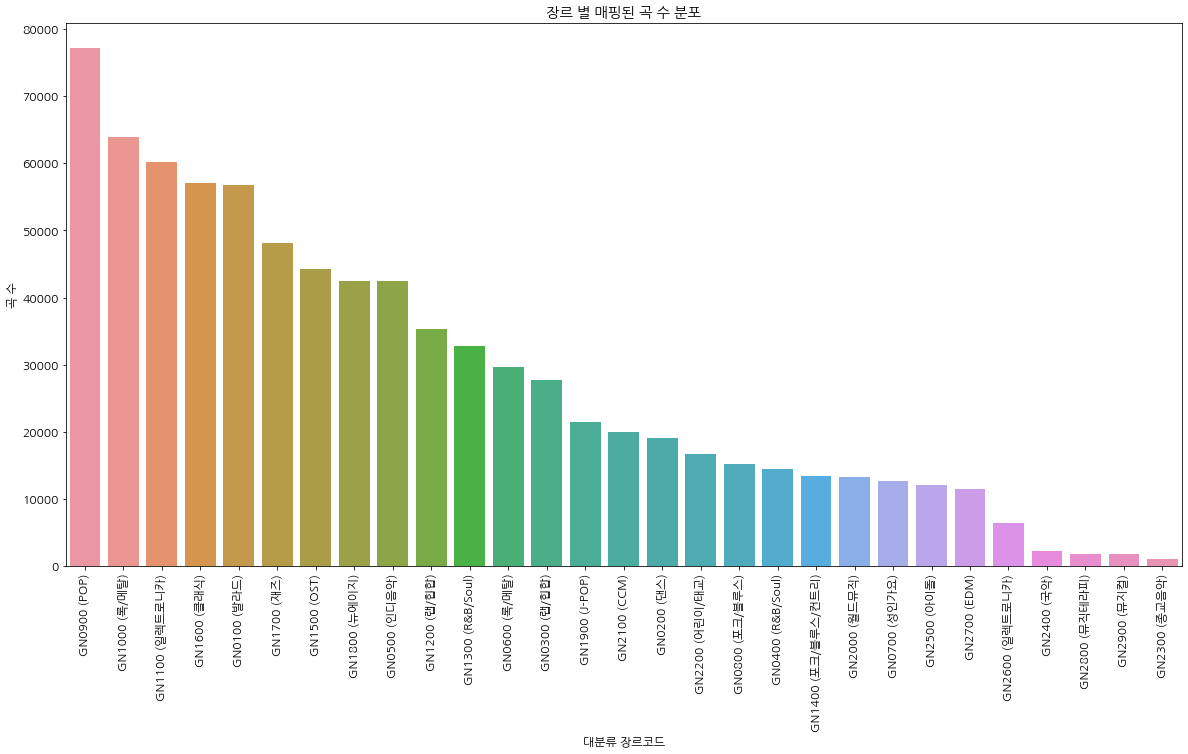

In [52]:
# 1. 장르 별 곡 수 count 테이블 생성 : gnr_count
gnr_count = song_gnr_map.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')

# 2. 1번 테이블과 장르 meta와 join
gnr_count = pd.merge(gnr_count, gnr_code.loc[:, ['gnr_code', 'gnr_name']], how = 'left', on = 'gnr_code')
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + ' (' + gnr_count['gnr_name'] + ')'

# 3. 매핑이 되지 않은 일부 곡들은 제거
gnr_count = gnr_count[['gnr_code_name', 'song_cnt']].dropna()

# 4. 많은 곡이 매핑된 순 기준으로 내림차순 리스트 생성
gnr_list_desc = gnr_count.sort_values('song_cnt', ascending = False).gnr_code_name

# 5. plotting
gnr_code_name_plot = sns.barplot(x = 'gnr_code_name', y = 'song_cnt', data = gnr_count, order = gnr_list_desc)
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)
plt.show()

#### 발매 년도 별 곡 비중은?
- 1990년 이후로 각 곡들의 발매년도 별 곡의 비중을 확인해본 결과 2014~2019년도에 발매된 곡의 비중이 높음.
(실제 전체 메타 풀에서 약 50% 정도의 비중을 보임)

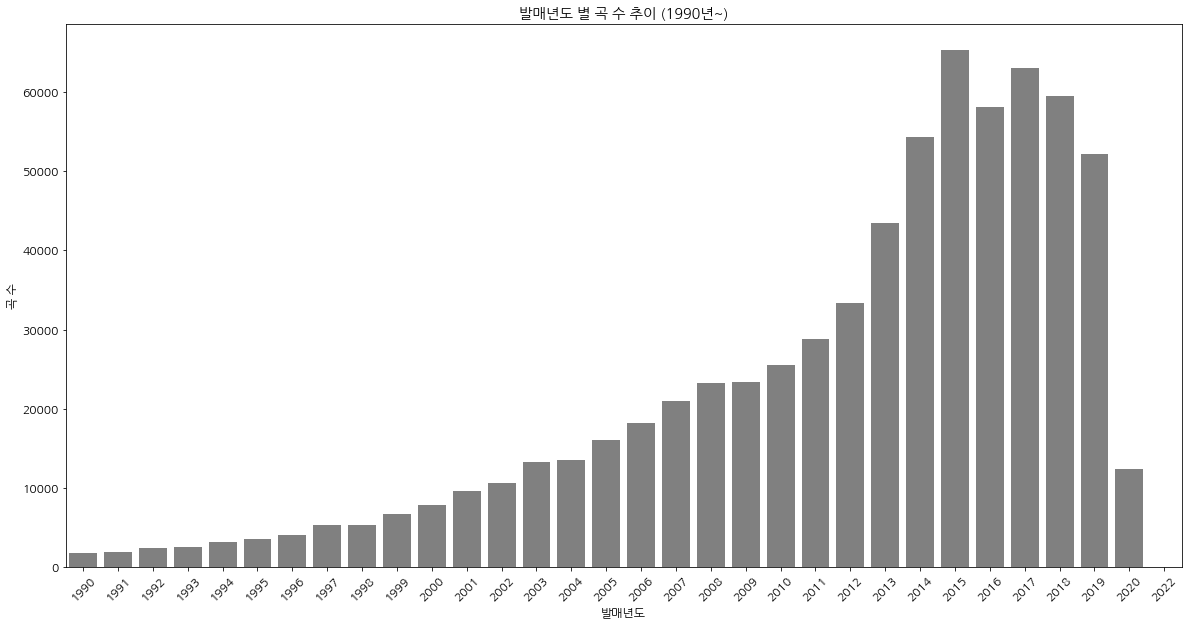

In [53]:
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_year) 변수 생성
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

# 3. 1990년도~ 필터링
song_issue_date_filter = song_issue_date[song_issue_date.issue_year >= '1990']

# 4. 발매년도 별 곡 수 count 테이블 생성 : issue_year_song_cnt
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year').song_id.nunique().reset_index(name = 'song_cnt')

# 5. plotting
issue_year_song_cnt_plot = sns.barplot(x = 'issue_year', y = 'song_cnt', data = issue_year_song_cnt, color = 'grey')
issue_year_song_cnt_plot.set_title('발매년도 별 곡 수 추이 (1990년~)')
issue_year_song_cnt_plot.set_xlabel('발매년도')
issue_year_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation = 45)
plt.show()

### 1.3 학습 데이터: train.json

#### 데이터 불러오기
학습 데이터에는 총 115,071개 플레이리스트 정보가 담겨져 있으며 포함하는 값:
- tags : 플레이리스트에 매핑된 태그
- id : 플레이리스트 아이디
plylst_title : 플레이리스트 명
- songs : 플레이리스트 내 수록된 곡 아이디
- like_cnt : 플레이리스트 좋아요 횟수
- updt_date : 플레이리스트 업데이트 일시

In [54]:
train = pd.read_json('train.json', typ = 'frame')

In [55]:
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [57]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = train[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# unnest 객체 제거
del plylst_song_map_unnest

In [58]:
plylst_song_map

,id,songs
0,61281,525514
1,61281,129701
2,61281,383374
3,61281,562083
4,61281,297861
...,...,...
5285866,100389,111365
5285867,100389,51373
5285868,100389,640239
5285869,100389,13759


In [59]:
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

In [60]:
plylst_tag_map

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한
...,...,...
476326,131982,퇴근길
476327,100389,노래추천
476328,100389,팝송추천
476329,100389,팝송


내 생각) 보이는 것과 같이 같은 팝송이여도 '팝송', '팝송모음', '팝송 추천'등 유사한 태그들이 보임.

In [61]:
train_uniq_song_cnt = plylst_song_map.songs.nunique() # 유니크 곡 수
train_uniq_tag_cnt = plylst_tag_map.tags.nunique() # 유니크 태그 수

print('곡 수 : %s' %train_uniq_song_cnt)
print('태그 수 : %s' %train_uniq_tag_cnt)

곡 수 : 615142
태그 수 : 29160


#### 플레이 리스트 별 곡/태그/장르 수 분포는?

**수록곡**
- 플레이리스트 별 수록된 곡 수의 분포를 확인해본 결과 **평균 약 46개(중앙값 30개)의 곡이 수록**되어 있으며 최대 200곡의 수록곡을 포함한 플레이리스트가 존재.

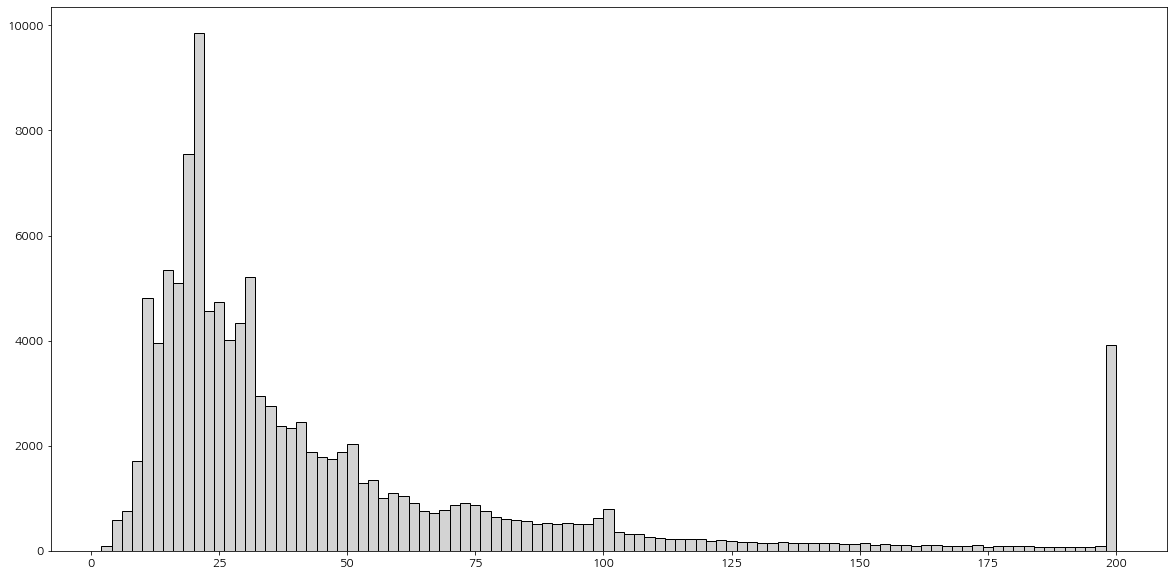

In [62]:
# 1. 플레이리스트 별 수록곡 수 count 테이블 생성 : plylst_song_cnt
plylst_song_cnt = pd.DataFrame(plylst_song_map.groupby('id').songs.nunique())

# 2-1. grid setting
grid_list = [i*2 for i in range(1, 101)]

# 2-2. plotting
plt.hist(plylst_song_cnt['songs'], grid_list, color = "lightgrey", edgecolor = "black")
plt.show()

In [63]:
round(plylst_song_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)
# 기본 기술통계량을 가로로 보여주는 방법

,min,25%,50%,mean,75%,max,std
songs,1.0,19.0,30.0,45.94,54.0,200.0,43.95


내 생각) 저 200곡 수록 플레이리스트는 뭘까?

**태그**
- 플레이리스트 당 **태그**는 **평균 약 4.1개(중앙값 3개)가 포함**되어 있으며 가장 많은 태그 수는 11개.


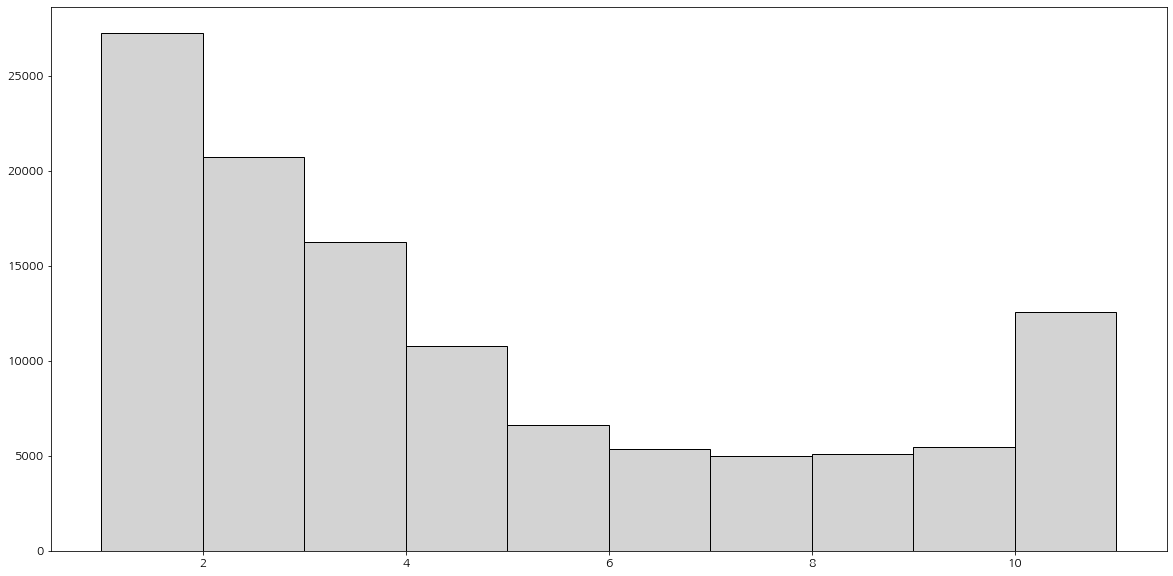

In [64]:
# 1. 플레이리스트 별 매핑 태그 수 count 테이블 생성 : plylst_tag_cnt
plylst_tag_cnt = pd.DataFrame(plylst_tag_map.groupby('id').tags.nunique())

# 2. plotting
plt.hist(plylst_tag_cnt['tags'], range(1, 12), color = "lightgrey", edgecolor = "black")
plt.show()

In [65]:
round(plylst_tag_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags,1.0,2.0,3.0,4.14,6.0,11.0,3.07


**장르**
- 플레이리스트에 수록된 곡에서 대분류 장르 수 분포를 확인해본 결과 플레이리스트 당 **평균 6.6개(중앙값 6개)의 장르를 포함**하고 있음.

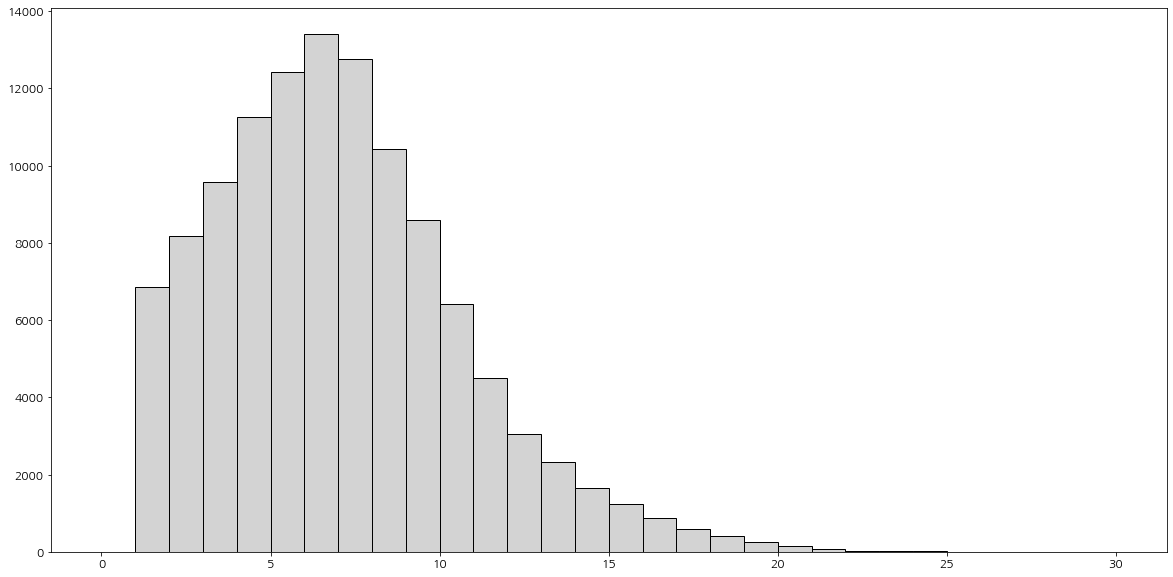

In [66]:
# 1-1. join 목적으로 곡 아이디 integer to string 변환
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# 1-2. 플레이리스트-곡 테이블 plylst_song_map + 곡-장르 테이블 song_gnr_map join
plylst_song_gnr_map = pd.merge(plylst_song_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 2. 플레이리스트 별 곡 장르 수 count 테이블 생성 : plylst_song_gnr_cnt
plylst_song_gnr_cnt = pd.DataFrame(plylst_song_gnr_map.groupby('id').gnr_code.nunique())

# 3. plotting
plt.hist(plylst_song_gnr_cnt['gnr_code'], range(0, 31), color = "lightgrey", edgecolor = "black")
plt.show()

In [67]:
round(plylst_song_gnr_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
gnr_code,0.0,4.0,6.0,6.55,9.0,26.0,3.62


#### 곡/태그/플레이리스트명 중복 비율?

**중복 수록 곡 비중**
- **수록 곡의 약 51%는 두 개 이상의 플레이리스트에 중복 수록**된 곡.

In [68]:
# 1. 곡 별 수록된 플레이리스트 개수 count 테이블 생성 : song_plylst_cnt
song_plylst_cnt = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 수록 구분 : 곡 별 수록된 플레이리스트가 한 개면 '단일 수록', 두 개 이상이면 '중복 수록'
song_plylst_cnt = song_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(song_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 수록', '중복 수록'])
)

# 3. 단일/중복 수록 구분 별 곡 수 count 테이블 생성 : song_plylst_mapping_division
song_plylst_mapping_division = pd.DataFrame(song_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
song_plylst_mapping_division.rename(columns = {'songs' : '곡 수'}, inplace = True)
song_plylst_mapping_division.loc[:, '비율(%)'] = round(song_plylst_mapping_division['곡 수']/sum(song_plylst_mapping_division['곡 수'])*100, 2)
song_plylst_mapping_division = song_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 수록 여부'})
song_plylst_mapping_division[['중복 수록 여부', '곡 수', '비율(%)']]

,중복 수록 여부,곡 수,비율(%)
0,단일 수록,299028,48.61
1,중복 수록,316114,51.39


아래는 **중복 수록** 곡 중 많이 **수록된 횟수 기준** 상위 30**곡**.

In [69]:
# 1. song_plylst_cnt 테이블에서 중복 수록 곡 중 수록 횟수 기준 상위 30곡 필터링 테이블 생성 : duplicate_song_top30
duplicate_song_top30 = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '중복 수록'].nlargest(30, 'mapping_plylst_cnt')

# 2-1. join 목적으로 곡 아이디 integer to string 변환
duplicate_song_top30['songs'] = duplicate_song_top30['songs'].astype(str)
song_meta['id'] = song_meta['id'].astype(str)

# 2-2 상위 30곡 테이블 duplicate_song_top30 + 곡 메타 song_meta join
(
    pd.merge(duplicate_song_top30, song_meta[['id', 'song_name', 'artist_name_basket']],
             how = 'left', left_on = 'songs', right_on = 'id')
    [['songs', 'song_name', 'artist_name_basket', 'mapping_plylst_cnt']]
    .rename(columns = {'songs' : '곡 아이디', 'song_name' : '곡 명', 'artist_name_basket' : '아티스트 명', 'mapping_plylst_cnt' : '수록 횟수'})
)

,곡 아이디,곡 명,아티스트 명,수록 횟수
0,144663,밤편지,[아이유],2175
1,116573,안아줘,[정준일],2121
2,357367,비,[폴킴],1981
3,366786,가끔 미치도록 네가 안고 싶어질 때가 있어,[가을방학],1919
4,654757,눈의 꽃,[박효신],1647
5,133143,"그대와 나, 설레임 (Feat. 소울맨)",[어쿠스틱 콜라보],1633
6,349492,어떤이별,[임승부],1599
7,675115,야생화,[박효신],1598
8,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)],1544
9,42155,벙어리,[홍아],1540


아래는 **단일 수록** 곡 중 가장 많은 곡이 수록된 **장르** 상위 30개.

In [70]:
# 1. song_plylst_cnt 테이블에서 단일 수록 곡만 필터링 하여 테이블 생성 : single_song
single_song = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '단일 수록']

# 2-1. join 목적으로 곡 아이디 integer to string 변환
single_song['songs'] = single_song['songs'].astype(str)

# 2-2. 단일 수록 곡 테이블 single_song + 곡 메타 song_meta join : 아티스트 기준 single_song_artist, 장르 기준 single_song_gnr
single_song_artist = pd.merge(single_song, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id')
single_song_gnr = pd.merge(single_song, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 수록 곡 개수 기준 상위 30개 장르 : single_song_gnr_cnt
single_song_gnr_cnt = single_song_gnr.groupby('gnr_code').songs.nunique().reset_index(name = 'song_cnt')
(
    pd.merge(single_song_gnr_cnt, genre_gn_all, how = 'left', on = 'gnr_code')[['gnr_code', 'gnr_name', 'song_cnt']]
    .rename(columns = {'gnr_code' : '대분류 장르코드', 'gnr_name' : '장르명', 'song_cnt' : '수록 곡 수'})
    .sort_values('수록 곡 수', ascending = False)
)

,대분류 장르코드,장르명,수록 곡 수
15,GN1600,클래식,32841
8,GN0900,POP,30987
9,GN1000,록/메탈,30028
10,GN1100,일렉트로니카,25725
16,GN1700,재즈,23158
17,GN1800,뉴에이지,19370
14,GN1500,OST,16855
11,GN1200,랩/힙합,15054
0,GN0100,발라드,14575
12,GN1300,R&B/Soul,13136


**중복 매핑 태그 비중**
- 태그의 매핑 중복 비율을 확인해본 결과 **전체 대비 약 40.2%는 두 개 이상 플레이리스트에 매핑된 태그**이며
한 개 플레이리스트에만 매핑된 태그는 과반 이상의 비중을 차지.

In [71]:
# 1. 태그 별 수록된 플레이리스트 개수 count 테이블 생성 : tag_plylst_cnt
tag_plylst_cnt = plylst_tag_map.groupby('tags').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 매핑 구분 : 태그 별 매핑된 플레이리스트가 한 개면 '단일 매핑', 두 개 이상이면 '중복 매핑'
tag_plylst_cnt = tag_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(tag_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 매핑', '중복 매핑'])
)

# 3. 단일/중복 매핑 구분 별 태그 수 count 테이블 생성 : tag_plylst_mapping_division
tag_plylst_mapping_division = pd.DataFrame(tag_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
tag_plylst_mapping_division.rename(columns = {'tags' : '태그 수'}, inplace = True)
tag_plylst_mapping_division.loc[:, '비율(%)'] = round(tag_plylst_mapping_division['태그 수']/sum(tag_plylst_mapping_division['태그 수'])*100, 2)
tag_plylst_mapping_division = tag_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 매핑 여부'})
tag_plylst_mapping_division[['중복 매핑 여부', '태그 수', '비율(%)']]

,중복 매핑 여부,태그 수,비율(%)
0,단일 매핑,17431,59.78
1,중복 매핑,11729,40.22


**플레이리스트명 중복 비중**
- 또한 **플레이리스트 아이디는 다르지만 같은 이름을 갖는 플레이리스트도 전체 대비 약 2% 정도**로 소수 존재.
- 이러한 플레이리스트들은 대부분 곡 수와 태그 수도 비슷한 편이 많았음.

In [72]:
# 1. 플레이리스트 아이디(id)와 플레이리스트 명(plylst_title) 추출
plylst_title = train[['id', 'plylst_title']]

# 2. 플레이리스트 이름 별 플레이리스트 ID count 테이블 생성 : plylst_id_cnt
plylst_id_cnt = plylst_title.groupby('plylst_title').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 3. 플레이리스트 명 중복 구분 : 서로 다른 플레이리스트 아이디로 겹치는 플레이리스트 이름이 없으면 '중복 없음', 그 외 '중복 있음'
plylst_id_cnt = plylst_id_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(plylst_id_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['중복 없음', '중복 있음'])
)

# 4. 중복 구분 별 플레이리스트 수 count 테이블 생성 : plylst_id_cnt_division
plylst_id_cnt_division = pd.DataFrame(plylst_id_cnt.groupby('mapping_plylst_cnt_category').count())

# 5. 4번 테이블에 비율 값 추가
plylst_id_cnt_division.rename(columns = {'mapping_plylst_cnt' : '플레이리스트 아이디 수'}, inplace = True)
plylst_id_cnt_division.loc[:, '비율(%)'] = round(plylst_id_cnt_division['플레이리스트 아이디 수']/sum(plylst_id_cnt_division['플레이리스트 아이디 수'])*100, 2)
plylst_id_cnt_division = plylst_id_cnt_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 이름 여부'})
plylst_id_cnt_division.loc[:, ['중복 이름 여부', '플레이리스트 아이디 수', '비율(%)']]

,중복 이름 여부,플레이리스트 아이디 수,비율(%)
0,중복 없음,108214,97.9
1,중복 있음,2317,2.1


내 생각) 결론: 중복 수록된 곡이나 태그는 어느 정도 존재하지만 플레이리스트명은 대부분 유일한 값을 가짐.
→ 그러나 과연 다른 값으로 봐야되는 지는 나중 향후 과제

#### 많은 빈도를 보이는 태그? (Word Cloud)
- 매핑 기준 상위 1,000번 이상 매핑된 태그를 살펴본 결과 **기분전환 태그명이 가장 높은 비중을 차지**하고 있으며
여름/가을/겨울 등 계절이나 드라이브, 카페, 매장음악 등 특정 상황과 어울리는 태그 등이 상위권에 분포되어 있음.
- 발라드, 힙합, 팝, 인디, 락, 댄스, 뉴에이지 등 **장르와 관련된 태그도 일부 상위권**에 속함.


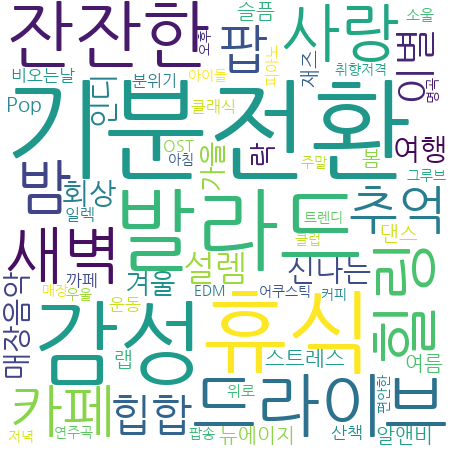

In [73]:
# 태그 별 매핑 빈도 수 저장 
tag_cnt = plylst_tag_map.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
tag_cnt['tags'] = tag_cnt['tags'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
tag_cnt = tag_cnt[tag_cnt['mapping_cnt'] >= 1000]
word_count = list(zip(tag_cnt['tags'], tag_cnt['mapping_cnt']))

# plotting
wc = WordCloud(font_path = font_path, background_color = 'white', max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

- 플레이리스트에 매핑된 태그 리스트를 기준으로 매핑 기준 상위 50개를 확인해본 결과 **다른 태그와 조합 없는 장르 관련 태그가 상위권을 차지**하고 있으며, 발라드 단일 태그가 가장 많았음.
- 이 밖에 **가장 빈도가 높았던 기분전환 태그명은 휴식, 힐링 뿐만 아니라 스트레스, 드라이브, 사랑, 설렘 등 다양한 태그와 같이 조합을 이루는 케이스가 많았음**.

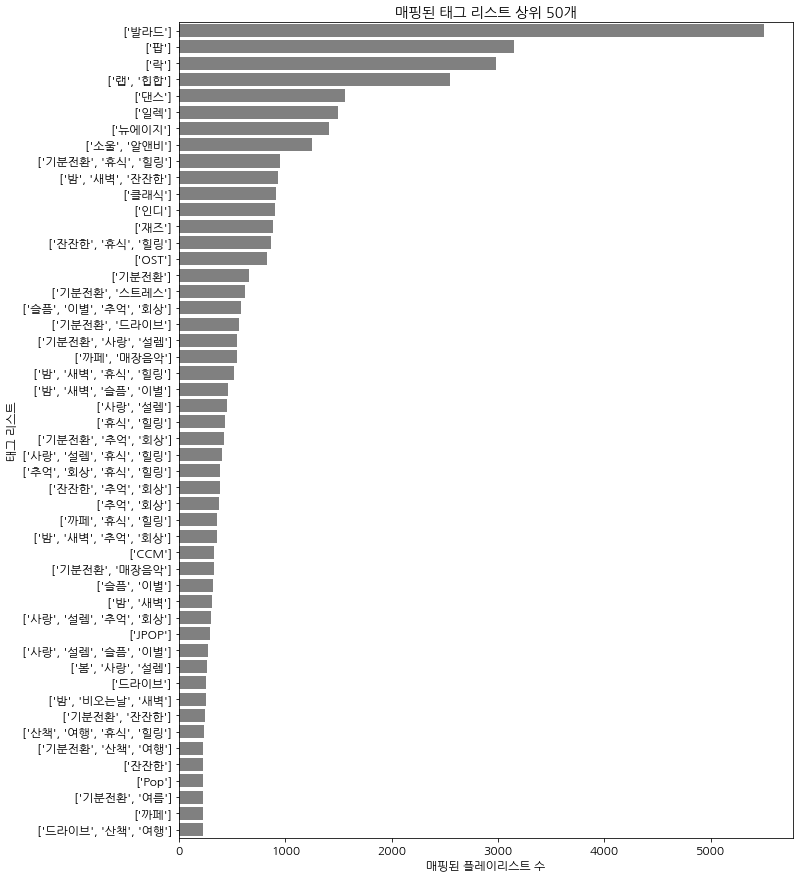

In [74]:
# 1. unnest 데이터프레임인 plylst_tag_map 테이블에서 태그 이름 정렬 후 list로 묶기
plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_cnt
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 50개 필터링
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(50, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (11, 15))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_cnt, color = 'grey')
tag_list_plylst_cnt_plot.set_title('매핑된 태그 리스트 상위 50개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

#### 플레이리스트 태그 별 수록된 곡?
- **드라이브, 스트레스, 기분전환 태그가 매핑된 플레이리스트와 카페, 매장음악 태그**가 매핑된 플레이리스트에서는 **팝(GN0900) 장르와 일렉(GN1100)장르**가 많았음.
- 이 밖에 **대부분 태그**에서 **발라드(GN0100) 곡 비중이 가장 높았**으며 **슬픔, 이별 태그**가 매핑된 플레이리스트에서는 **발라드 비중이 가장 높았음**.
밤, 새벽, 잔잔한, 휴식, 힐링 등의 태그가 있는 플레이리스트에서는 발라드 다음으로 팝 장르 비중이 높았음.
- **추억, 회상 태그**가 매핑된 플레이리스트에서는 **OST 비중이 발라드 다음으로 높음**.
- 이와 같이 태그 별 플레이리스트 수록 곡 특징을 탐색하여 플레이리스트의 곡 장르 성격을 추정해볼 수 있음.


In [75]:
# 1. 플레이리스트-곡 테이블 plylst_song_map + 플레이리스트-태그 테이블 plylst_tag_map join 테이블 생성 : plylst_song_tag_map
plylst_song_tag_map = pd.merge(plylst_song_map, plylst_tag_map, how = 'left', on = 'id')

# 2. 1번 테이블 plylst_song_tag_map + 곡 장르 테이블 song_gnr_map join
plylst_song_tag_map = pd.merge(plylst_song_tag_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 2번 테이블에서 장르 메타 join
gnr_code['gnr_code_name'] = gnr_code['gnr_code'] + ' (' + gnr_code['gnr_name'] + ')'
gnr_code = gnr_code[['gnr_code', 'gnr_code_name']]
plylst_song_tag_map = pd.merge(plylst_song_tag_map, gnr_code, how = 'left', on = 'gnr_code')

# 4. 최종 테이블 필드 선택
plylst_song_tag_map = plylst_song_tag_map[['id', 'songs', 'tags', 'gnr_code_name']]

내 생각) 아래 태그들을 나눈 기준은 멜론에서 일반적으로 유사 태그를 묶는 기준인가 보다.

In [76]:
# 태그 = ['드라이브', '스트레스', '기분전환']
song_tag_map_sample_1 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['드라이브', '스트레스', '기분전환']), :]
# 태그 = ['밤', '새벽', '잔잔한']
song_tag_map_sample_2 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['밤', '새벽', '잔잔한']), :]
# 태그 = ['사랑', '설렘']
song_tag_map_sample_3 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['사랑', '설렘']), :]
# 태그 = ['추억', '회상']
song_tag_map_sample_4 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['추억', '회상']), :]
# 태그 = ['슬픔', '이별']
song_tag_map_sample_5 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['슬픔', '이별']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_6 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['휴식', '힐링']), :]
# 태그 = ['카페', '매장음악']
song_tag_map_sample_7 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['카페', '매장음악']), :]

[kimhyunwoo님의 노트북](https://arena.kakao.com/forum/topics/228)에 따르면, 이번에 Melon Playlist Continuation으로 제공된 데이터들은 단순 플레이리스트가 아니라 `멜론 DJ 플레이리스트`라는 <u>멜론 유저가 직접 플레이리스트를 만들어 다른사람에게 공개한 리스트</u>라고 함. 단, 심사를 거쳐 공개가 되기 때문에 리스트 자체에 어느 정도 정형화된 데이터로 저장해 둘 수가 있음.

심사 기준은:
- **곡과 태그는 최소 10개, 2개 이상**이어야하고 제목은 반드시 있어야합니다. 그렇기에 val과 test에서 제목이 없는경우와 곡과 태그가 최소수를 만족하지 못하는 경우는 아레나측에서 임의로 지운 것으로 판단할 수 있습니다.
- **가수/앨범/곡의 고른 분배 및 배치** 라는 항목이 있습니다. 문장만 봐서는 동일한 가수와 동일한 앨범의 곡이 많이 들어가면 안된다는데 실제로 데이터가 그런지는 아래에서 확인해보겠습니다.
- **선곡의 테마 및 장르를 표현할 수 있어야 합**니다. DJ를 신청할 때는 반드시 아래의 테마 혹은 장르를 선택해야합니다. 그렇기에 플레이리스트가 어떤 테마 혹은 장르를 가지는 지 알 수 있다면, 모델의 성능을 더 좋아질 것으로 판단됩니다.

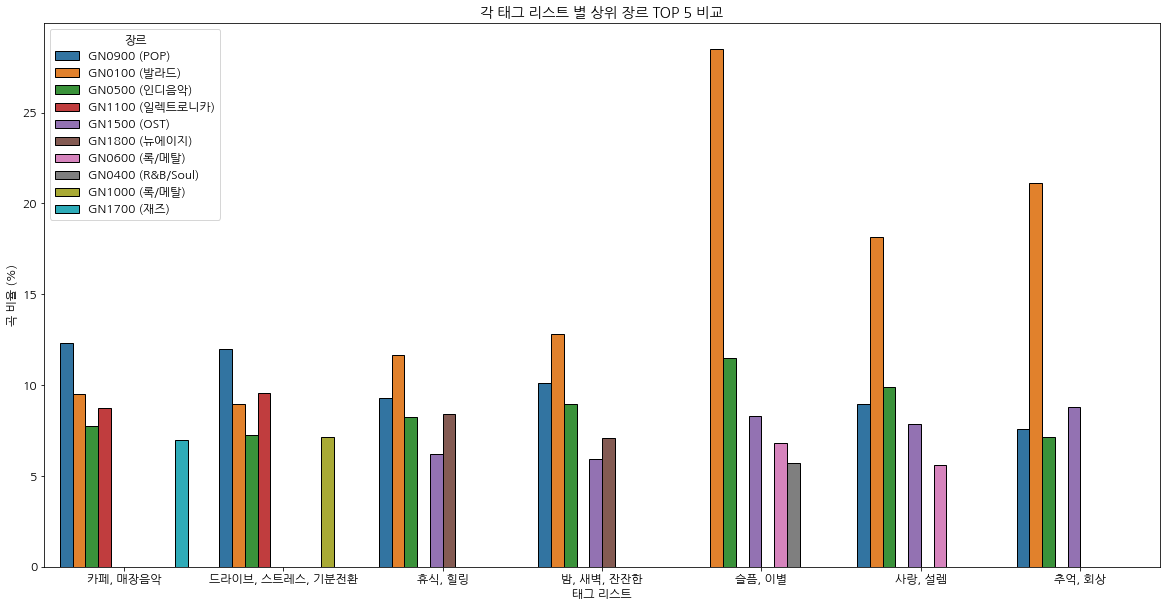

In [77]:
# 각 샘플 태그 리스트 별 장르 비율 집계
song_tag_map_sample_1_gnr_rank = song_tag_map_sample_1.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_1_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_1_gnr_rank['song_cnt']/sum(song_tag_map_sample_1_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_1_gnr_rank['gnr_rank'] = song_tag_map_sample_1_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_1_gnr_rank['tag_list'] = '드라이브, 스트레스, 기분전환'
song_tag_map_sample_1_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_2_gnr_rank = song_tag_map_sample_2.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_2_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_2_gnr_rank['song_cnt']/sum(song_tag_map_sample_2_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_2_gnr_rank['gnr_rank'] = song_tag_map_sample_2_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_2_gnr_rank['tag_list'] = '밤, 새벽, 잔잔한'
song_tag_map_sample_2_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_3_gnr_rank = song_tag_map_sample_3.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_3_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_3_gnr_rank['song_cnt']/sum(song_tag_map_sample_3_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_3_gnr_rank['gnr_rank'] = song_tag_map_sample_3_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_3_gnr_rank['tag_list'] = '사랑, 설렘'
song_tag_map_sample_3_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_4_gnr_rank = song_tag_map_sample_4.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_4_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_4_gnr_rank['song_cnt']/sum(song_tag_map_sample_4_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_4_gnr_rank['gnr_rank'] = song_tag_map_sample_4_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_4_gnr_rank['tag_list'] = '추억, 회상'
song_tag_map_sample_4_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_5_gnr_rank = song_tag_map_sample_5.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_5_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_5_gnr_rank['song_cnt']/sum(song_tag_map_sample_5_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_5_gnr_rank['gnr_rank'] = song_tag_map_sample_5_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_5_gnr_rank['tag_list'] = '슬픔, 이별'
song_tag_map_sample_5_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_6_gnr_rank = song_tag_map_sample_6.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_6_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_6_gnr_rank['song_cnt']/sum(song_tag_map_sample_6_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_6_gnr_rank['gnr_rank'] = song_tag_map_sample_6_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_6_gnr_rank['tag_list'] = '휴식, 힐링'
song_tag_map_sample_6_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_7_gnr_rank = song_tag_map_sample_7.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_7_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_7_gnr_rank['song_cnt']/sum(song_tag_map_sample_7_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_7_gnr_rank['gnr_rank'] = song_tag_map_sample_7_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_7_gnr_rank['tag_list'] = '카페, 매장음악'
song_tag_map_sample_7_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

# delete object
del song_tag_map_sample_1, song_tag_map_sample_2, song_tag_map_sample_3, song_tag_map_sample_4, song_tag_map_sample_5, song_tag_map_sample_6, song_tag_map_sample_7

# row binding
song_tag_map_sample_rbind = pd.concat(
    [song_tag_map_sample_1_gnr_rank, song_tag_map_sample_2_gnr_rank, song_tag_map_sample_3_gnr_rank,
     song_tag_map_sample_4_gnr_rank, song_tag_map_sample_5_gnr_rank, song_tag_map_sample_6_gnr_rank,
     song_tag_map_sample_7_gnr_rank],
    axis = 0
)

# plotting
song_tag_map_sample_rbind_plot = sns.barplot(
    data = song_tag_map_sample_rbind.loc[song_tag_map_sample_rbind['순위'] <= 5, :].sort_values(by = '순위'),
    x = '태그 리스트', y = '비율(%)', hue = '장르', edgecolor = "black"
)
song_tag_map_sample_rbind_plot.set_title('각 태그 리스트 별 상위 장르 TOP 5 비교')
song_tag_map_sample_rbind_plot.set_xlabel('태그 리스트')
song_tag_map_sample_rbind_plot.set_ylabel('곡 비율 (%)')
plt.show()

- 이 밖에 발매년도 기준으로 살펴본 결과 **추억, 회상이 매핑된 플레이리스트들**은 태그명처럼 다른 플레이리스트에 비해 **비교적 과거 발매 곡 비중이 조금 더 높은 편**을 확인할 수 있음.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

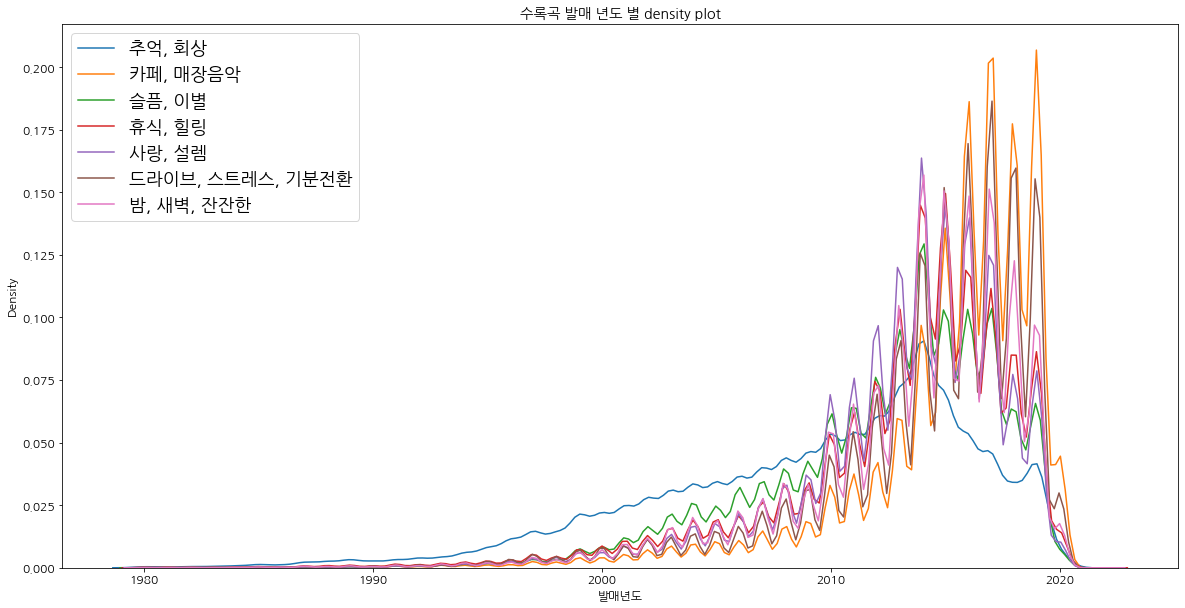

In [78]:
# 매우 오래 걸림 주의

# 위에서 생성한 테이블에서 곡 별 발매년도 join
plylst_song_tag_map_issue_year = pd.merge(plylst_song_tag_map, song_issue_date, how = 'left', left_on = 'songs', right_on = 'song_id')

# 샘플 태그들이 포함되어 있는 플레이리스트만 필터링
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year.loc[plylst_song_tag_map_issue_year.tags.isin(['드라이브', '스트레스', '기분전환', '밤', '새벽', '잔잔한', '사랑', '설렘', '추억', '회상', '슬픔', '이별', '휴식', '힐링', '카페', '매장음악']), :]
plylst_song_tag_map_issue_year_filter['issue_year'] = plylst_song_tag_map_issue_year_filter['issue_year'].apply(pd.to_numeric)
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year_filter[plylst_song_tag_map_issue_year_filter['issue_year'] >= 1980]

del plylst_song_tag_map_issue_year

# plotting
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['추억', '회상']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '추억, 회상')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['카페', '매장음악']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '카페, 매장음악')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['슬픔', '이별']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '슬픔, 이별')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['휴식', '힐링']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '휴식, 힐링')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['사랑', '설렘']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '사랑, 설렘')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['드라이브', '스트레스', '기분전환']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '드라이브, 스트레스, 기분전환')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['밤', '새벽', '잔잔한']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '밤, 새벽, 잔잔한')
plt.legend(prop = {'size' : 18})
plt.title('수록곡 발매 년도 별 density plot')
plt.xlabel('발매년도')
plt.ylabel('Density')
plt.show()

내 생각) 과거에는 추억, 회상을 태그로 갖는 곡들이 많이 발매되었으나, 점점 [카페, 매장음악], [드라이브, 스트레스, 기분전환], [밤, 새벽, 잔잔한] 노래가 발매되었음을 플레이리스트에 추가된 곡을 통해 알 수 잇음. (해석을 잘해야 될 것 같은 부분)

#### 역으로 곡 별 태그를 매핑해본다면?
- 각 플레이리스트에 한 개 이상의 태그들이 매핑되어 있고, 한 곡 이상의 곡들이 수록되어 있음.
- 이 부분을 고려하여 곡 별 수록된 플레이리스트의 태그 값을 매핑해본다면 곡의 메타 정보를 하나 더 파생시켜 볼 수 있음.

In [79]:
# 학습 데이터 내에서 가장 많은 태그가 매핑된 아이유 - 밤편지 (144663) 예시
example_song = plylst_song_tag_map[plylst_song_tag_map['songs'] == '144663']
example_song

,id,songs,tags,gnr_code_name
36032,7984,144663,슬픔,GN0100 (발라드)
36033,7984,144663,거짓말,GN0100 (발라드)
36034,7984,144663,이별,GN0100 (발라드)
36035,7984,144663,아픈,GN0100 (발라드)
115027,106802,144663,힐링,GN0100 (발라드)
...,...,...,...,...
29580419,13178,144663,새벽,GN0100 (발라드)
29580420,13178,144663,새벽아침,GN0100 (발라드)
29580421,13178,144663,활기찬,GN0100 (발라드)
29580422,13178,144663,산책,GN0100 (발라드)


- 곡 별로 매핑된 태그 값은 평균 18개(중앙값 7개)이고 예시로 들었던 아이유 - 밤편지 곡은 1,928개의 태그가 매핑됨.

In [80]:
# 곡 별 매핑되는 태그 수 집계 : song_tag_map_cnt
song_tag_map_cnt = plylst_song_tag_map.groupby('songs').tags.nunique().reset_index(name = 'tags_cnt')
round(song_tag_map_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags_cnt,1.0,2.0,7.0,17.86,15.0,1928.0,44.95


태그 기준으로 유사 느낌의 곡 찾기 (Ex. 아이유 - 밤편지)

In [81]:
example_song.groupby(['songs', 'tags']).id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)

,songs,tags,mapping_plylst_cnt
241,144663,감성,690
770,144663,발라드,543
1462,144663,잔잔한,413
1699,144663,카페,395
940,144663,새벽,339
...,...,...,...
782,144663,밤공기,1
781,144663,밤감성,1
779,144663,발랄한노래,1
778,144663,발라드핫트랙,1


- 아이유 - 밤편지 곡은 **감성** 태그를 갖는 690개의 플레이리스트에 수록되어 있음.
- 두 번째로 높은 태그는 **발라드**, 세 번째는 **잔잔한** 태그.

In [82]:
example_temp = plylst_song_tag_map.loc[plylst_song_tag_map['tags'] == '감성', :].groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)
pd.merge(example_temp, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id').head(10)

,songs,mapping_plylst_cnt,id,song_name,artist_name_basket
0,357367,735,357367,비,[폴킴]
1,144663,690,144663,밤편지,[아이유]
2,519391,678,519391,Love Again,[김제훈]
3,640657,667,640657,내가 말하고 싶은건,[김제훈]
4,463173,662,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)]
5,349492,659,349492,어떤이별,[임승부]
6,427724,653,427724,지워줄게 (Vocal by 스티브언니),[아재]
7,680366,650,680366,끝내지 못한 이야기 (Feat. 호수),[어쿠스틱 멜로디 (Acoustic Melody)]
8,520093,641,520093,고마운 사람 (Vocal by 이소진),[업라이트 (Upright)]
9,215411,639,215411,지금보다 조금 (Feat. 이원),[어쿠스틱 멜로디 (Acoustic Melody)]


- 위는 감성이라는 태그에 매핑되는 곡은 대략 10만곡으로 매핑 수 기준 상위 10곡.

---
이후는 [kimhyunwoo님의 노트북](https://arena.kakao.com/forum/topics/228)를 참고한 코드입니다.

### train / test data에 대한 이해

#### 플레이리스트 내의 등장횟수에 따른 노래의 개수
- 평균적으로 노래당 8.59개의 플레이리스트내에 수록이 되고 50%의 노래가 2개의 플레이리스트내에 수록되는 것을 알 수 있음. 가장 인기가 있는 노래는 아래와 같음.

In [84]:
def mapping_function(data, col1, col2): 
    # 플레이리스트 아이디(col1)와 수록곡(col2) 추출
    plylst_song_map = data[[col1, col2]]

    # unnest col2
    plylst_song_map_unnest = np.dstack(
        (
            np.repeat(plylst_song_map[col1].values, list(map(len, plylst_song_map[col2]))), 
            np.concatenate(plylst_song_map[col2].values)
        )
    )

    # unnested 데이터프레임 생성 : plylst_song_map
    plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
    plylst_song_map[col1] = plylst_song_map[col1].astype(str)
    plylst_song_map[col2] = plylst_song_map[col2].astype(str)

    # unnest 객체 제거
    del plylst_song_map_unnest
    return plylst_song_map

In [86]:
playlst_song_map = mapping_function(train, 'id', 'songs')
agg = pd.DataFrame(playlst_song_map['songs'].value_counts()).reset_index()
agg.columns = ['곡', '플레이리스트내의 등장횟수']
# meta['id'] = meta['id'].astype(str)
agg = agg.merge(song_meta[['id', 'artist_name_basket', 'song_name', 'song_gn_gnr_basket']], how='left', left_on='곡', right_on='id')

R에서 시각화 관련 패키지로 ggplot2를 가장 많이 사용하는데, python에서도 이패키지를 사용하고 싶다면 
```python
from plotnine import *
import plotnine
```
이 코딩 두줄은 필수.

`plotnint`은 matplotlib 패키지를 기본으로 하고 ggplot2의 문법을 사용할 수 있게 해 주는 패키지.  
하지만 R과 문법적인 면에서 차이가 있음.
1. ggplot문을 괄호로 감싸줘야 함.
2. 변수명 쌍따옴표(")로 감싸주기

In [108]:
from plotnine import *
import plotnine

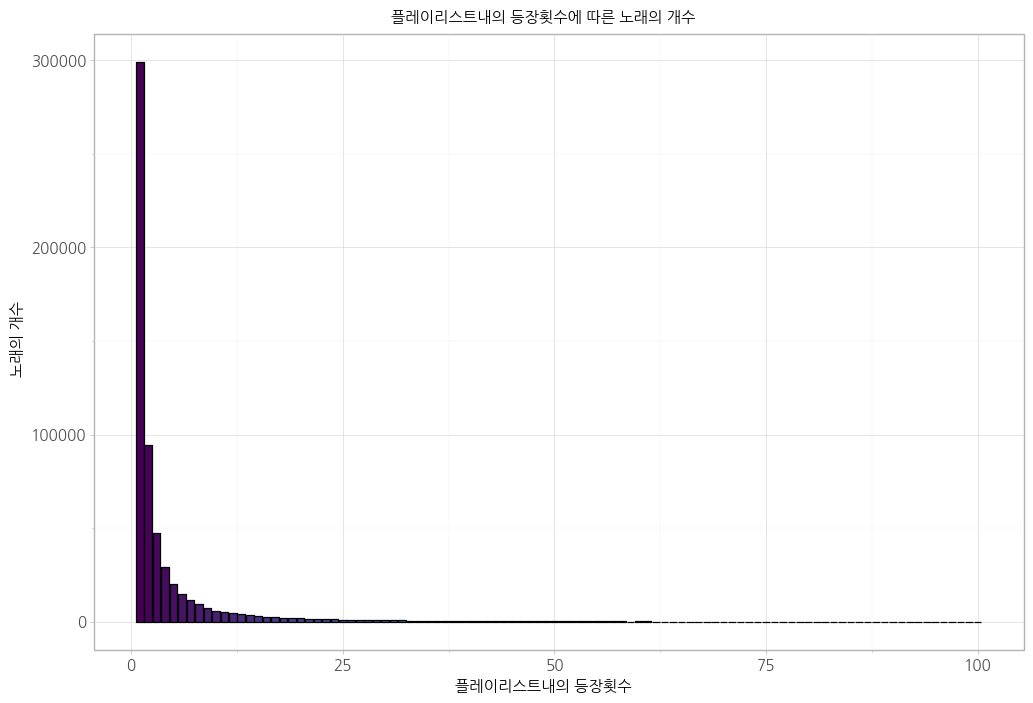

<ggplot: (8742469108601)>

In [114]:
song_count_df = agg.groupby(['플레이리스트내의 등장횟수'])['플레이리스트내의 등장횟수'].agg({'count'}).reset_index().rename(columns={'count':'노래의 개수'})
song_count_df100 = song_count_df[song_count_df['플레이리스트내의 등장횟수'] <= 100]

(ggplot(data=song_count_df100) 
    + geom_bar(aes(x="플레이리스트내의 등장횟수", y="노래의 개수", group="플레이리스트내의 등장횟수", fill="플레이리스트내의 등장횟수"), color='black', stat='identity')
    + scale_color_hue(l=0.45)
    + theme_light() 
    + labs(title = "플레이리스트내의 등장횟수에 따른 노래의 개수",
         x = "플레이리스트내의 등장횟수",
         y = "노래의 개수")
    + theme(text = element_text(fontproperties=font_name),
        #axis_text_x = element_text(angle=80),
        figure_size=(12,8),
        legend_position="none"))

In [115]:
print("플레이리스트내 1번 등장한 노래의 수:", agg[agg['플레이리스트내의 등장횟수'] == 1].shape[0])
print("플레이리스트내 2번 이상 등장한 노래의 수:", agg[agg['플레이리스트내의 등장횟수'] > 1].shape[0])

플레이리스트내 1번 등장한 노래의 수: 299028
플레이리스트내 2번 이상 등장한 노래의 수: 316114


In [116]:
round(pd.DataFrame(agg['플레이리스트내의 등장횟수'].describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']]).T, 2)

,min,25%,50%,mean,75%,max,std
플레이리스트내의 등장횟수,1.0,1.0,2.0,8.59,4.0,2175.0,39.48


플레이리스트에 가장 많이 등장한 노래

In [118]:
agg.loc[0:4][['artist_name_basket', 'song_name']]

,artist_name_basket,song_name
0,[아이유],밤편지
1,[정준일],안아줘
2,[폴킴],비
3,[가을방학],가끔 미치도록 네가 안고 싶어질 때가 있어
4,[박효신],눈의 꽃


#### 플레이리스트 내의 등장횟수에 따른 장르의 개수
플레이리스트 단일 장르, 복수 장르

In [123]:
playlst_genre_map = mapping_function(agg, 'id', 'song_gn_gnr_basket')
playlst_1 = playlst_genre_map[playlst_genre_map['id'].isin(agg[agg['플레이리스트내의 등장횟수'] == 1]['id'].values)].rename(columns={'song_gn_gnr_basket':'gnr_code'})
playlst_2 = playlst_genre_map[playlst_genre_map['id'].isin(agg[agg['플레이리스트내의 등장횟수'] > 1]['id'].values)].rename(columns={'song_gn_gnr_basket':'gnr_code'})

genre_gn = pd.DataFrame(genre_gn_all)
playlst_1 = playlst_1.merge(genre_gn, how='left', on='gnr_code')
playlst_2 = playlst_2.merge(genre_gn, how='left', on='gnr_code')

플레이리스트에 1번 등장한 장르


In [125]:
playlst_1.groupby(['gnr_name'])['gnr_name'].agg({'count'}).reset_index().sort_values(by='count', ascending=False).head(10)

,gnr_name,count
10,록/메탈,39414
22,클래식,32841
4,POP,30987
19,일렉트로니카,28017
20,재즈,23158
9,랩/힙합,22766
7,뉴에이지,19370
3,OST,16855
5,R&B/Soul,16261
13,발라드,14575


플레이리스트에 2번 이상 등장한 장르

In [126]:
playlst_2.groupby(['gnr_name'])['gnr_name'].agg({'count'}).reset_index().sort_values(by='count', ascending=False).head(10)

,gnr_name,count
10,록/메탈,41515
13,발라드,37986
4,POP,37101
9,랩/힙합,33802
19,일렉트로니카,29926
5,R&B/Soul,26431
18,인디음악,26296
3,OST,22131
20,재즈,18350
7,뉴에이지,17047


#### 플레이리스트 내의 등장횟수에 따른 태그의 개수
- 노래와 태그의 플레이리스트내 등장 횟수는 비슷한 양상을 보임. 하지만, 노래보다는 태그의 경우가 1번 나온 경우가 많음. 그리고 평균도 노래가 8.59인 반면에 태그는 16.34으로 약 2배에 가깝움. 편차는 39.48에 비해 247.01으로 6배 가까이 높음. 이를 보아서, 태그의 경우 노래보다 등장하는 값들만 등장하는 것을 파악할 수 있음.

In [127]:
playlst_tag_map = mapping_function(train, 'id', 'tags')
agg = pd.DataFrame(playlst_tag_map['tags'].value_counts()).reset_index()
agg.columns = ['태그', '플레이리스트내의 등장횟수']

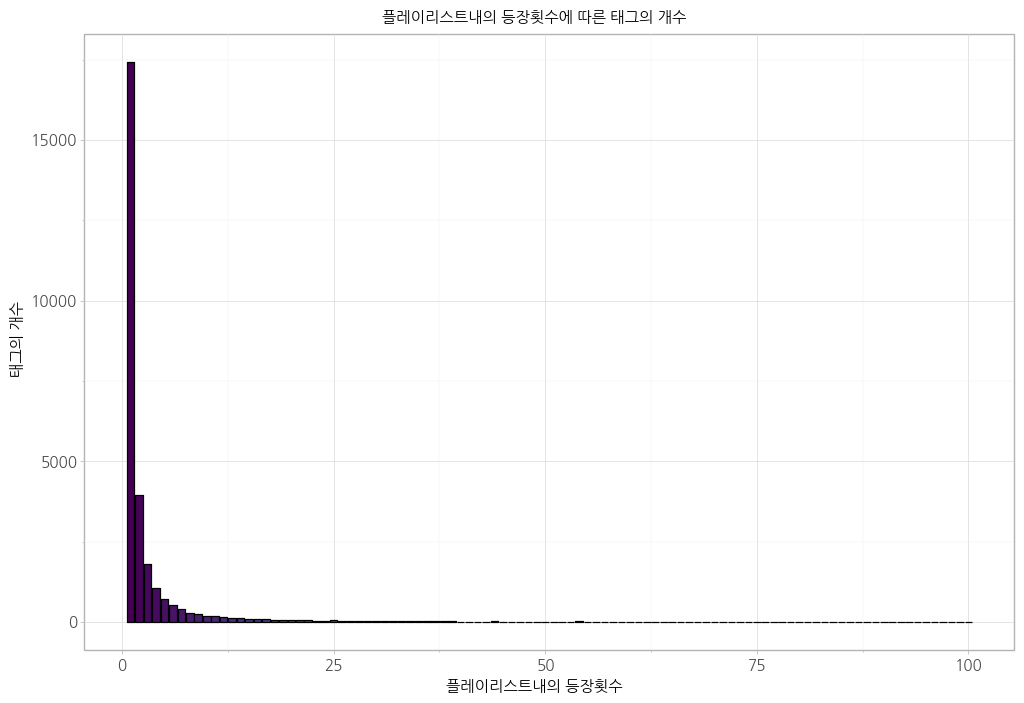

<ggplot: (8742465939905)>

In [128]:
tag_count_df = agg.groupby(['플레이리스트내의 등장횟수'])['플레이리스트내의 등장횟수'].agg({'count'}).reset_index().rename(columns={'count':'태그의 개수'})
tag_count_df100 = tag_count_df[tag_count_df['플레이리스트내의 등장횟수'] <= 100]

(ggplot(data=tag_count_df100) 
    + geom_bar(aes(x='플레이리스트내의 등장횟수', y='태그의 개수', group='플레이리스트내의 등장횟수', fill='플레이리스트내의 등장횟수'), color='black', stat='identity')
    + scale_color_hue(l=0.45)
    + theme_light() 
    + labs(title = '플레이리스트내의 등장횟수에 따른 태그의 개수',
         x = '플레이리스트내의 등장횟수',
         y = '태그의 개수')
    + theme(text = element_text(fontproperties=font_name),
        #axis_text_x = element_text(angle=80),
        figure_size=(12,8),
        legend_position="none"))

In [130]:
print("플레이리스트내 1번 등장한 태그의 수:", agg[agg['플레이리스트내의 등장횟수'] == 1].shape[0])
print("플레이리스트내 2번 이상 등장한 태그의 수:", agg[agg['플레이리스트내의 등장횟수'] > 1].shape[0])

플레이리스트내 1번 등장한 태그의 수: 17431
플레이리스트내 2번 이상 등장한 태그의 수: 11729


In [131]:
round(pd.DataFrame(agg['플레이리스트내의 등장횟수'].describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']]).T, 2)

,min,25%,50%,mean,75%,max,std
플레이리스트내의 등장횟수,1.0,1.0,1.0,16.34,3.0,16465.0,247.01


실제 자주 등장하는 태그와 그렇지 않은 태그를 비교해보면 자주 등장하는 태그들이 좀 더 명확한 것을 볼 수 있음. 그리고 재밌는 것은 위의 태그들중에 아래의 테마/장르에 속하는 태그들이 있다는 점임.

In [132]:
agg.sort_values(by='플레이리스트내의 등장횟수', ascending=False)[0:10]['태그'].values

array(['기분전환', '감성', '휴식', '발라드', '잔잔한', '드라이브', '힐링', '사랑', '새벽', '밤'],
      dtype=object)

In [133]:
agg[agg['플레이리스트내의 등장횟수'] == 1]['태그'].values

array(['빗방물', '찜통더위', '우울해지고싶을때듣는노래', ..., '같은곡다른느낌', '오디션출신', ''],
      dtype=object)

이러한 특성을 잘 이용한다면, 곡들로 특정 태그를 유추하고 특정 태그들로 장르/테마를 유추하는 것 또한 가능해보임.

내 생각) 플레이리스트 생성 창에서 이미 테마 / 장르 선택란으로 태그명 선택에 영향을 준 것 같아 보임.

In [ ]:
# [이후 genre, mel, meta 에 대한 이해 continue ...]

---
### 향후과제
[ ]발매 년도 별 시각화 그래프는 density plot 이용할 거면 오르내리는 그래프보다 최고점을 찍은걸 이은 그래프가 낫지 않을 까?